In [56]:
# IMPORTANDO BIBLIOTECAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
!pip install fsspec
import fsspec
warnings.filterwarnings("ignore")



In [57]:
# Baixar dados do Ibovespa pelo yfinance (de 2013 a 2022)
ibov = yf.download('^BVSP', start='2013-01-01', end='2022-12-31')

# Ajustar as colunas para o nível 0 (Price), que tem os nomes corretos (Close, Open, etc)
ibov.columns = ibov.columns.get_level_values(0)

# Resetar índice para transformar o índice Date em coluna
ibov.reset_index(inplace=True)

# Selecionar apenas as colunas Date e Close
df_ibov = ibov[['Date', 'Close']].copy()

# Renomear coluna Close para Ibovespa
df_ibov.rename(columns={'Close': 'Ibovespa'}, inplace=True)

# Visualizar resultado
print(df_ibov.head())

[*********************100%***********************]  1 of 1 completed

Price       Date  Ibovespa
0     2013-01-02   62550.0
1     2013-01-03   63312.0
2     2013-01-04   62523.0
3     2013-01-07   61933.0
4     2013-01-08   61128.0


In [58]:
# Defina o caminho completo do arquivo dos indicadores econômicos
caminho_indicadores = 'C://Python DSA//Projeto_Impacto_B3//Dados Brutos//raw//economic_indicators.csv'

# Importar os indicadores econômicos, parseando a coluna 'Date'
df_economic = pd.read_csv(caminho_indicadores, parse_dates=['Date'])

print(df_economic.head())



        Date  Taxa Selic  IPCA  IGP-M  INPC  Desemprego PNADC
0 2010-01-01        8.75  0.75   0.63  0.88               NaN
1 2010-01-02        8.75   NaN    NaN   NaN               NaN
2 2010-01-03        8.75   NaN    NaN   NaN               NaN
3 2010-01-04        8.75   NaN    NaN   NaN               NaN
4 2010-01-05        8.75   NaN    NaN   NaN               NaN


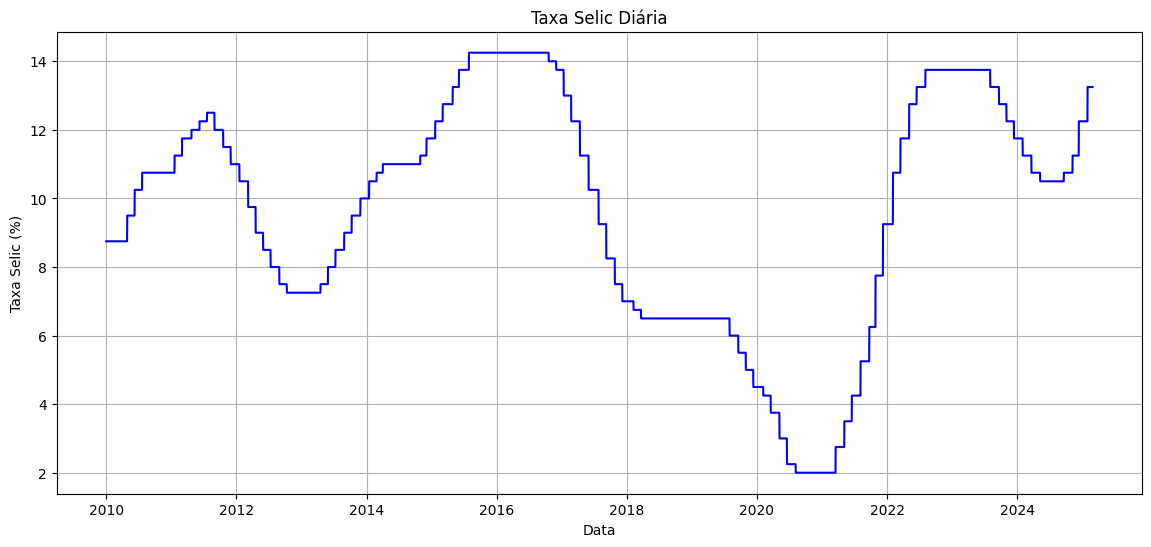

In [59]:
# Usar só a coluna Taxa Selic com a data como índice
df_selic = df_economic[['Date', 'Taxa Selic']].dropna()
df_selic.set_index('Date', inplace=True)

# Plotar a série temporal diária da Taxa Selic
plt.figure(figsize=(14,6))
plt.plot(df_selic.index, df_selic['Taxa Selic'], color='blue')
plt.title('Taxa Selic Diária')
plt.xlabel('Data')
plt.ylabel('Taxa Selic (%)')
plt.grid(True)
plt.show()


In [67]:
# Pega só a coluna Taxa Selic
df_selic = df_economic[['Taxa Selic']]

# Reindexa df_selic para ter exatamente as datas do df_ibov
df_selic_alinhado = df_selic.reindex(df_ibov.index)

# Junta as duas bases pelo índice (datas)
df_final = pd.concat([df_selic_alinhado, df_ibov], axis=1)

print(df_final.head())
print(df_final.info())
print(df_final.isna().sum())



            Taxa Selic  Ibovespa
Date                            
2013-01-02        7.25   62550.0
2013-01-03        7.25   63312.0
2013-01-04        7.25   62523.0
2013-01-07        7.25   61933.0
2013-01-08        7.25   61128.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2476 entries, 2013-01-02 to 2022-12-29
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Taxa Selic  2476 non-null   float64
 1   Ibovespa    2476 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB
None
Taxa Selic    0
Ibovespa      0
dtype: int64


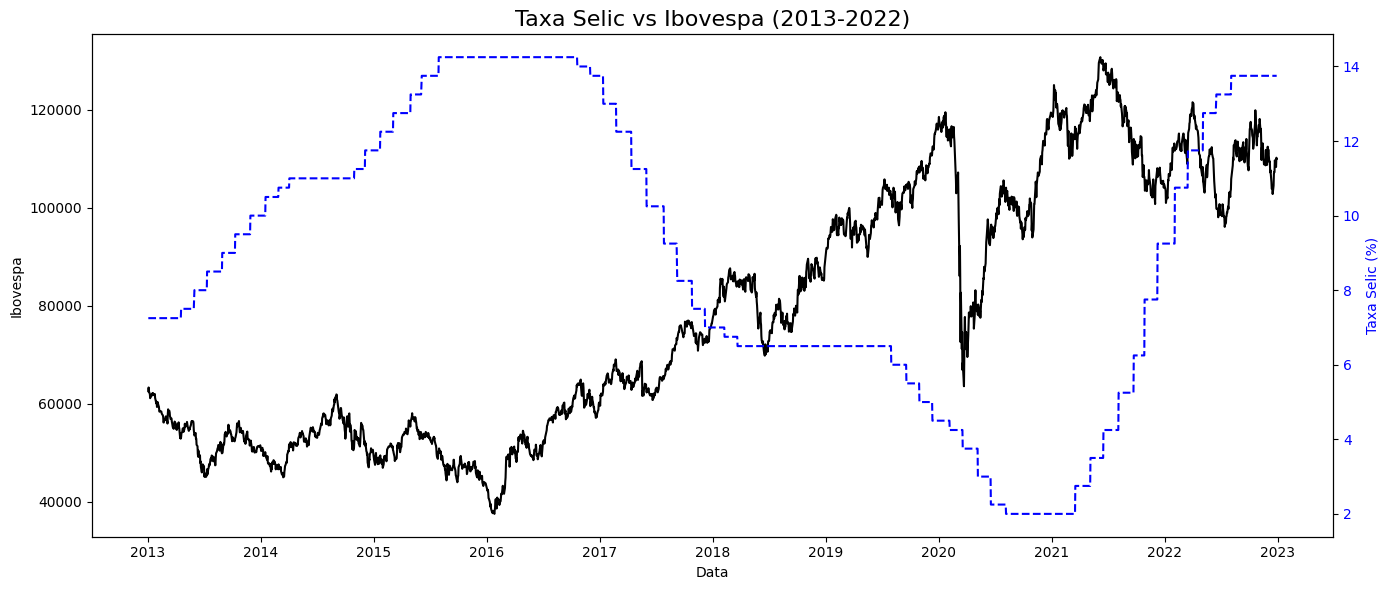

In [68]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Ibovespa (linha preta)
ax1.set_title('Taxa Selic vs Ibovespa (2013-2022)', fontsize=16)
ax1.set_xlabel('Data')
ax1.set_ylabel('Ibovespa', color='black')
ax1.plot(df_final.index, df_final['Ibovespa'], color='black', label='Ibovespa')
ax1.tick_params(axis='y', labelcolor='black')

# Selic (linha azul em outro eixo)
ax2 = ax1.twinx()
ax2.set_ylabel('Taxa Selic (%)', color='blue')
ax2.plot(df_final.index, df_final['Taxa Selic'], color='blue', linestyle='--', label='Taxa Selic')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()
plt.show()


In [ ]:
df_final.index = pd.to_datetime(df_final.index)
df_final = df_final.sort_index()

# Criar coluna da Selic anterior para detectar mudanças
df_final['Selic Anterior'] = df_final['Taxa Selic'].shift(1)

# Filtrar as linhas onde a Taxa Selic mudou
df_selic_change = df_final[df_final['Taxa Selic'] != df_final['Selic Anterior']].copy()

# Calcular retorno acumulado do Ibovespa nos 45 dias úteis após a mudança
resultados = []
for data in df_selic_change.index:
    futuros = df_final.loc[data:].iloc[1:46]  # 45 dias úteis após a mudança
    if len(futuros) < 45:
        retorno = np.nan
    else:
        ibov_inicio = df_final.loc[data, 'Ibovespa']
        ibov_fim = futuros['Ibovespa'].iloc[-1]
        retorno = (ibov_fim / ibov_inicio) - 1
    resultados.append(retorno)

df_selic_change['Retorno_45dias'] = resultados

# Remover coluna auxiliar
df_selic_change.drop(columns=['Selic Anterior'], inplace=True)

# Mostrar total de mudanças e resultado
print(f"Total de mudanças da Selic detectadas: {len(df_selic_change)}")
print(df_selic_change[['Taxa Selic', 'Retorno_45dias']])




Total de mudanças da Selic detectadas: 50
            Taxa Selic  Retorno_45dias
Date                                  
2013-01-02        7.25       -0.064029
2013-04-18        7.50       -0.135444
2013-05-31        8.00       -0.094756
2013-07-11        8.50        0.143289
2013-08-29        9.00        0.086815
2013-10-10        9.50       -0.051267
2013-11-28       10.00       -0.100739
2014-01-16       10.50       -0.034268
2014-02-27       10.75        0.122146
2014-04-03       11.00        0.062169
2014-10-30       11.25       -0.045742
2014-12-04       11.75       -0.061971
2015-01-22       12.25        0.036406
2015-03-05       12.75        0.127608
2015-04-30       13.25       -0.072560
2015-06-05       13.75       -0.068337
2015-07-30       14.25       -0.057398
2016-10-20       14.00       -0.081738
2016-12-01       13.75        0.075386
2017-01-12       13.00       -0.015230
2017-02-23       12.25       -0.038511
2017-04-13       11.25       -0.032853
2017-06-01       10.25

In [73]:

# Estatísticas descritivas básicas
estatisticas = df_selic_change[['Taxa Selic', 'Retorno_45dias']].describe()

print("Estatísticas Descritivas:")
print(estatisticas)

# Também podemos verificar a variação da Selic entre reuniões para analisar impacto da mudança
df_selic_change['Variação Selic'] = df_selic_change['Taxa Selic'] - df_selic_change['Taxa Selic'].shift(1)

print("\nVariação da Taxa Selic entre reuniões:")
print(df_selic_change['Variação Selic'].describe())


Estatísticas Descritivas:
       Taxa Selic  Retorno_45dias
count   50.000000       50.000000
mean     8.770000        0.009400
std      3.606909        0.103668
min      2.000000       -0.306207
25%      6.062500       -0.063341
50%      9.125000       -0.010601
75%     11.750000        0.075038
max     14.250000        0.280508

Variação da Taxa Selic entre reuniões:
count    49.000000
mean      0.132653
std       0.707295
min      -1.000000
25%      -0.500000
50%       0.250000
75%       0.500000
max       1.500000
Name: Variação Selic, dtype: float64


# TIVEMOS 50 MUDANÇAS NA TAXA SELIC DURANTE O PERIODO ANALISADO. 
# A TAXA SELIC TEVE UMA MÉDIA DE 8,7%, mostrando ter tido periodos com uma politica monetaria mais contracionista do que expansionista no periodo, ou seja, provavelmente mais cenarios de controle inflacionario. 
# OLHANDO PARA O RETORNO 45 DIAS, COMO O IBOVESPA SE COMPORTOU DURANTE OS 45 DIAS SEGUINTES AS REUNIOES DO COPOM ONDE TIVEMOS MUDANÇAS NA TAXA? Retorno 45 dias = (Ibovespa no 45º dia após a mudança / Ibovespa no dia da mudança) - 1
# ABAIXO VAMOS VALIDAR A HIPOTESE SE HOUVE IMPACTO OU NAO

In [81]:
# Correlação positiva (+1): Quando uma variável aumenta, a outra também tende a aumentar.

# Correlação negativa (-1): Quando uma variável aumenta, a outra tende a diminuir.

# Correlação zero (0): Não há relação linear entre as variáveis.

corr = df_selic_change['Variação Selic'].corr(df_selic_change['Retorno_45dias'])
print(f'Correlação de Pearson: {corr:.4f}')


Correlação de Pearson: -0.1927


In [84]:
# Remove linhas com NaN para garantir que o cálculo funcione
df_corr = df_selic_change[['Variação Selic', 'Retorno_45dias']].dropna()

# Calcula correlação e p-valor
_, p_value = pearsonr(df_corr['Variação Selic'], df_corr['Retorno_45dias'])

print(f'P-valor: {p_value:.4f}')


P-valor: 0.1847


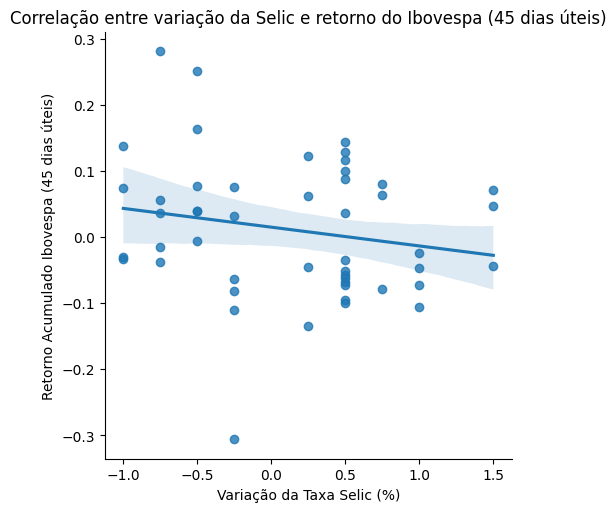

In [76]:
sns.lmplot(x='Variação Selic', y='Retorno_45dias', data=df_selic_change)
plt.title('Correlação entre variação da Selic e retorno do Ibovespa (45 dias úteis)')
plt.xlabel('Variação da Taxa Selic (%)')
plt.ylabel('Retorno Acumulado Ibovespa (45 dias úteis)')
plt.show()

# ANALISANDO OS CALCULOS, PODEMOS CONCLUIR QUE NÃO HÁ EVIDENCIAS ESTATISTICAS SUFICIENTES PARA AFIRMAR QUE A CORRELACAO OBSERVADA É DIFERENTE DE ZERO COM 95% DE CONFIANÇA, OU SEJA, O RESULTADO INDICA QUE A CORRELAÇÃO NEGATIVA BAIXA DE -0,19 PODE TER OCORRIDO POR ACASO. 

# Conclusão da Análise Exploratória (EDA)
Nesta análise exploratória, investigamos a relação entre as variações da Taxa Selic definidas nas reuniões do COPOM e o retorno acumulado do índice Ibovespa nos 45 dias úteis subsequentes, utilizando dados históricos do período de janeiro de 2013 a dezembro de 2022.

Os principais pontos observados foram:

Calculamos a variação da Selic em cada reunião e o retorno acumulado do Ibovespa nos 45 dias úteis seguintes a essas variações.

O coeficiente de correlação de Pearson entre a variação da Selic e o retorno do Ibovespa foi de aproximadamente -0,19, indicando uma associação negativa fraca.

Entretanto, o teste estatístico apresentou um p-valor de 0,18, acima do nível de significância usual de 5%, o que indica que essa correlação não é estatisticamente significativa.

Assim, não há evidências suficientes para afirmar que as variações da Taxa Selic impactam o retorno do Ibovespa no curto prazo, dentro do horizonte de 45 dias úteis analisado.

Essa conclusão sugere que outros fatores além da política monetária provavelmente exercem influência mais relevante sobre o desempenho do mercado acionário no curto prazo. Recomenda-se aprofundar a análise incluindo outras variáveis macroeconômicas, testar diferentes horizontes temporais, e aplicar modelos econométricos que capturem relações dinâmicas e causais.

Esses próximos passos seriam essenciais para fornecer insights mais robustos e úteis para a tomada de decisão da Tesouraria e demais áreas envolvidas.